# SPARC-4 Pipeline Tools
## Night:``2023-06-04``
## Modes: ``POLARIMETRY``
***

This notebook shows an example of the full reduction of the SPARC4 data in the [minidata package](https://drive.google.com/file/d/1tAVjyhYGMDcrU5sDdGCmd_f5HoazZ294/view?usp=drive_link) using the SPARC4 pipeline tools. 

* Author: Eder Martioli, LNA 18 Apr 2024

In [1]:
import os, sys
import sparc4.product_plots as s4plt
import sparc4.pipeline_lib as s4pipelib
import sparc4.utils as s4utils
import glob
import warnings
warnings.filterwarnings('ignore')

## User inputs and initial setup

Before starting the reduction, we must configure a few parameters. The pipeline comes with default values for all parameters. To modify these, one can create and edit their own parameter file, then load it into the ``PARAMS_FILE`` variable. Alternatively, parameters can be changed by directly resetting the dictionary entry for a specific parameter, like this: ``p['PARAM_NAME'] = PARAM_NEW_VALUE``. See examples below. 

In [2]:
# set night directory name
NIGHTDIR = '20230604'
# set raw data root directory
ROOTDATADIR =  "/Users/eder/Data/SPARC4/minidata/"
# set reduced data root directory
ROOTREDUCEDDIR = "/Users/eder/Data/SPARC4/minidata/reduced/"
# set reduced data root directory
PIPELINEDIR = "/Users/eder/sparc4-pipeline/"
# define path to default calibration directory
calibdb_dir = os.path.join(PIPELINEDIR, "calibdb/")

# select a SPARC4 channel: 1 (g), 2 (r), 3 (i) or 4 (z)
CHANNEL = 1  

# set path to a parameters file:
#PARAMS_FILE = ""  # to use deafult values
PARAMS_FILE = os.path.join(PIPELINEDIR,"user_files/my_params.yaml")

# set path to a target list file
# this is to force targets to be included in the source catalog in addition to those detected automatically
TARGET_LIST_FILE = os.path.join(PIPELINEDIR,"user_files/targets.csv")

# initialize pipeline parameters
p = s4pipelib.init_s4_p(NIGHTDIR,
                        ROOTDATADIR,
                        ROOTREDUCEDDIR,
                        print_report=False,
                        param_file=PARAMS_FILE)

# get data dir
datadir = p['data_directories'][CHANNEL-1]
# get reduce dir
reducedir = p['reduce_directories'][CHANNEL-1]

# to force reduction even if products already exist
FORCE = False

###############################################################
# Below are a few examples on how to manually reset parameters: 
###############################################################

# set astrometry reference image as the one for this channel
p["ASTROM_REF_IMG"] = os.path.join(calibdb_dir, p["ASTROM_REF_IMGS"][CHANNEL-1])

# to build stacks of 10 images instead of the default value of 16 images
p['NFILES_FOR_STACK'] = 10

# to change the S/N threshold for detecting sources
# -- note that lower values will result in more (fainter) sources being detected.
p['PHOT_THRESHOLD'] = 100

# uncomment below to print all parameters and their respective values:
#for key in p.keys():
#    print("p['{}']={}".format(key,p[key]))

***
# <font color='darkblue'>Bias and Flat-field calibrations</font> 

In this section we build the master bias and flat-field calibrations.

## Define input list and output master product file names

In [3]:
# create a list of zeros for current detector mode
zero_list = glob.glob("{}/{}".format(datadir,"*zero*.fits"))

# define file name of master bias 
p["master_bias"] = "{}/{}_s4c{}_MasterZero.fits".format(reducedir,
                                                        NIGHTDIR,
                                                        CHANNEL)

# create a list of flats for current detector mode
flat_list = glob.glob("{}/{}".format(datadir,"*dflat*.fits"))

# define file name of master flat
p["master_flat"] = "{}/{}_s4c{}_MasterDomeFlat.fits".format(reducedir,
                                                            NIGHTDIR,
                                                            CHANNEL)

# Run master calibration

The master calibration routine combines a list of calibration files into a master calibration image.

In [4]:
# calculate master bias and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=zero_list, 
                                     output=p["master_bias"], 
                                     obstype='bias', 
                                     data_dir=datadir, 
                                     reduce_dir=reducedir, 
                                     force=FORCE)

bias files: 3
gain: 3.37 electron / adu
processing frame 1 of 3
processing frame 2 of 3


2024-04-18 16:23:07,255 astropop - INFO - Combining 3 images with median method.  [imcombine]


processing frame 3 of 3
Normalization mean value: 1696.9880836296081 electron


In [5]:
# calculate master dome flat and save product to FITS
p = s4pipelib.run_master_calibration(p, 
                                     inputlist=flat_list, 
                                     output=p["master_flat"], 
                                     obstype='flat', 
                                     data_dir=datadir, 
                                     reduce_dir=reducedir, 
                                     normalize=True, 
                                     force=FORCE)

flat files: 3
gain: 3.37 electron / adu
processing frame 1 of 3
processing frame 2 of 3


2024-04-18 16:23:07,711 astropop - INFO - Combining 3 images with median method.  [imcombine]


processing frame 3 of 3
Normalization mean value: 41350.75659287452 electron


# Plot master calibration results

Now, we plot the results to check if they look fine. 

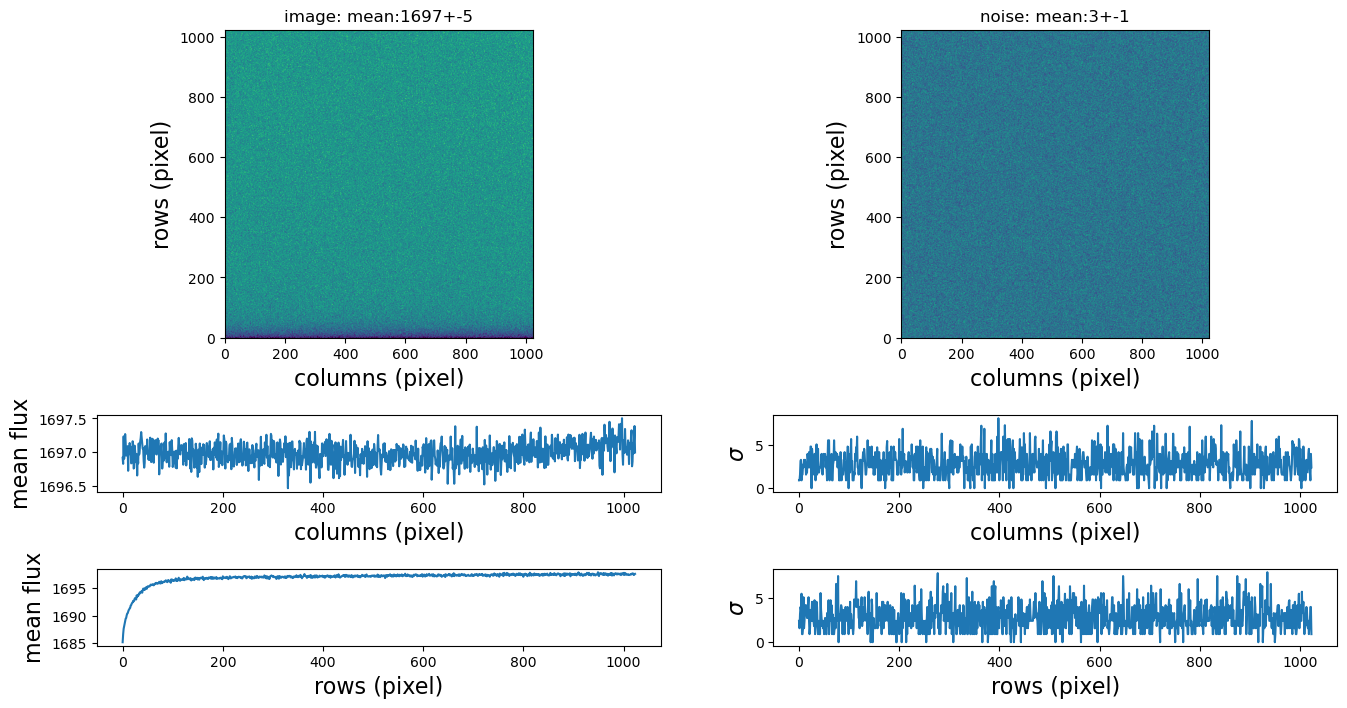

In [6]:
# plot master bias
s4plt.plot_cal_frame(p["master_bias"], 
                     percentile=99.5, 
                     combine_rows=True, 
                     combine_cols=True)

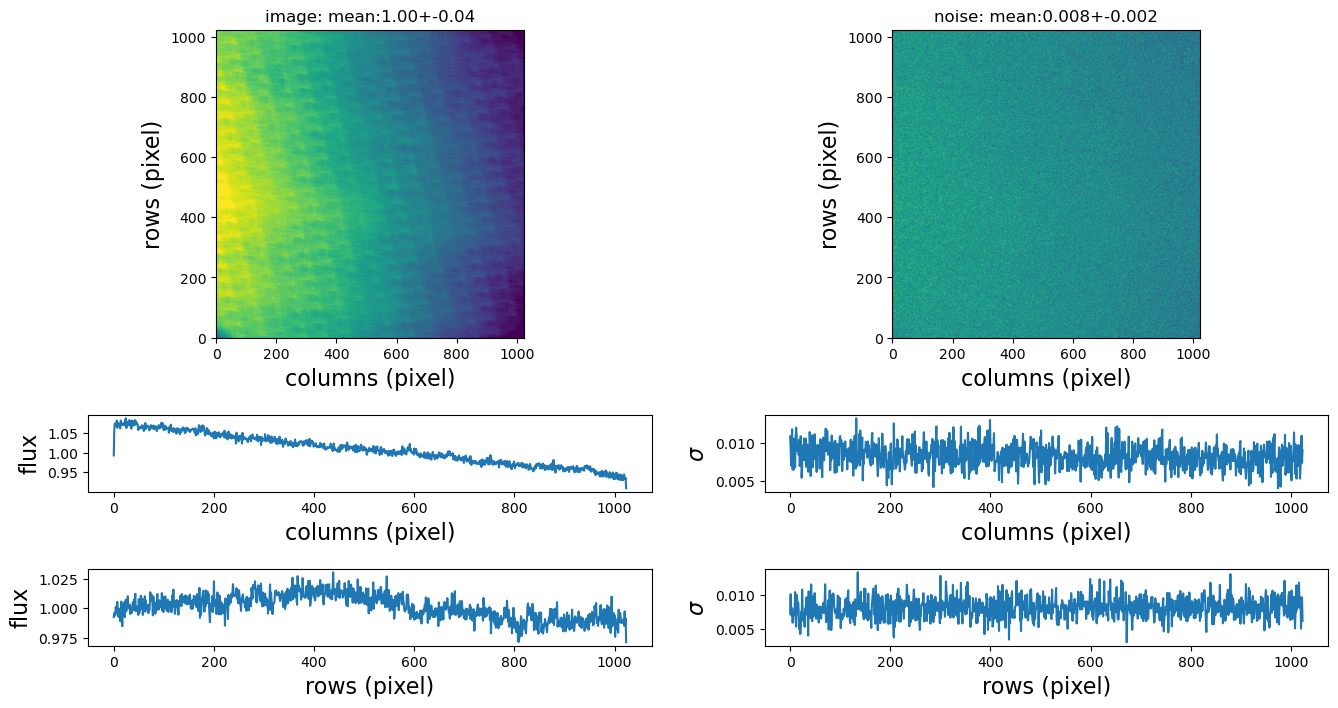

In [7]:
# plot master flat
s4plt.plot_cal_frame(p["master_flat"], 
                     percentile=99.5, 
                     xcut=512, 
                     ycut=512)

***
# <font color='darkblue'>Science image reduction - Polarimetry</font> 

In this section we reduce the science data. In this example we show the reduction processes for the following observations:

* The polarimetric standard [Hilt 652](https://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Hilt+652&submit=SIMBAD+search) observed in polarimetric mode.  It was observed in 16 rotating positions of the waveplate, equally spaced by 22.5 degrees, utilizing both L/2 and L/4 waveplate retarders.

## Select Hilt 652 data

In [8]:
# set an object ID matching the ID in the image header keyword 'OBJECT'
OBJECTID = "Hilt 652" # HD111579 is a polarimetric standard

# create a list of science data 
pol_list = glob.glob("{}/{}".format(datadir,"*stdpol.fits"))

# set instrument mode to "POLAR"
inst_mode = p['INSTMODE_POLARIMETRY_KEYVALUE']

FORCE = False

## Reduce scientific exposures in `POLARIMETRY HALF-WAVE (L/2)` mode

To reduce scientific frames, run the routine ``s4pipelib.stack_and_reduce_sci_images``. This routine performs calibration for detector gain, bias, and flat-field. Then, a subset of frames is stacked to generate a stack product. Source detection is then conducted within the stack frame, and the identified sources are cross-referenced with a catalog to establish an astrometric solution and generate a master catalog for all input observations of this field. The polarimetric pairs (dual beam) are matched and organized into two distinct catalogs. Aperture photometry is computed for several aperture sizes across all sources and for all input image frames. Finally, the resulting calibrated images and their associated photometric catalogs are saved into ``proc.fits`` product FITS files.

In [9]:
# initial set up
polar_mode = p['POLARIMETRY_L2_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode,polar_mode)

# set suffix for output stack filename
l2_stack_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR, 
                                        CHANNEL, 
                                        OBJECTID.replace(" ",""), 
                                        polsuffix)

# make a list of half-wave files (L2)
pol_l2_list = s4utils.select_fits_files_with_keyword(pol_list, 'WPSEL', 'L2')

0 Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000473_stdpol.fits
OBJECT files: 10
Loading science frames to memory ... 
gain: 3.37 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 10 : 20230604_s4c1_000473_stdpol.fits 
Calibrating science frame 2 of 10 : 20230604_s4c1_000476_stdpol.fits 
Calibrating science frame 3 of 10 : 20230604_s4c1_000482_stdpol.fits 
Calibrating science frame 4 of 10 : 20230604_s4c1_000481_stdpol.fits 
Calibrating science frame 5 of 10 : 20230604_s4c1_000475_stdpol.fits 
Calibrating science frame 6 of 10 : 20230604_s4c1_000479_stdpol.fits 
Calibrating science frame 7 of 10 : 20230604_s4c1_000484_stdpol.fits 
Calibrating science frame 8 of 10 : 20230604_s4c1_000483_stdpol.fits 
Calibrating science frame 9 of 10 : 20230604_s4c1_000477_stdpol.fits 
Calibrating science frame 10 of 10 : 20230604_s4c1_000472_stdpol.fits 


2024-04-18 16:23:12,588 astropop - INFO - Registering image 1 from 10  [register]
2024-04-18 16:23:12,590 astropop - INFO - Images are equal, skipping registering.  [register]


Registering science frames and stacking them ... 
0 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000473_stdpol.fits
1 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000476_stdpol.fits
2 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000482_stdpol.fits
3 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000481_stdpol.fits
4 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000475_stdpol.fits
5 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000479_stdpol.fits
6 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000484_stdpol.fits
7 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000483_stdpol.fits
8 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000477_stdpol.fits
9 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000472_stdpol.fits


2024-04-18 16:23:12,808 astropop - INFO - Registering image 2 from 10  [register]
2024-04-18 16:23:12,896 astropop - INFO - Filling registered image with cval=670.05  [register]
2024-04-18 16:23:12,900 astropop - INFO - Registering image with: translation=[-1.   -0.25], rotation=0.00°  [register]
2024-04-18 16:23:13,072 astropop - INFO - Registering image 3 from 10  [register]
2024-04-18 16:23:13,153 astropop - INFO - Filling registered image with cval=666.52  [register]
2024-04-18 16:23:13,158 astropop - INFO - Registering image with: translation=[-0.25 -1.  ], rotation=0.00°  [register]
2024-04-18 16:23:13,277 astropop - INFO - Registering image 4 from 10  [register]
2024-04-18 16:23:13,368 astropop - INFO - Filling registered image with cval=670.35  [register]
2024-04-18 16:23:13,370 astropop - INFO - Registering image with: translation=[-1.  -0.5], rotation=0.00°  [register]
2024-04-18 16:23:13,511 astropop - INFO - Registering image 5 from 10  [register]
2024-04-18 16:23:13,604 as

Creating new catalog of detected sources:
Solving astrometry in POLAR-MODE using astrometry_from_existing_wcs()
Running photometry for multiple apertures:
Aperture radius of 6 pixels: 1 of 6 :
Aperture radius of 8 pixels: 2 of 6 :
Aperture radius of 10 pixels: 3 of 6 :
Aperture radius of 12 pixels: 4 of 6 :
Aperture radius of 14 pixels: 5 of 6 :
Aperture radius of 16 pixels: 6 of 6 :
The 16 images will be reduced in 1 loops of 100 images each time
Running loop 0 of 1 -> images in loop: 0 to 16 ... 
OBJECT files: 16
Creating output list of processed science frames ... 
1 of 16 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604/20230604_s4c1_000473_stdpol_proc.fits
2 of 16 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604/20230604_s4c1_000476_stdpol_proc.fits
3 of 16 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604/20230604_s4c1_000482_stdpol_proc.fits
4 of 16 is reduced? False -> /Users

2024-04-18 16:23:24,865 astropop - INFO - Computing shift of image 1 from 16  [register]
2024-04-18 16:23:24,867 astropop - INFO - Computing shift of image 2 from 16  [register]
2024-04-18 16:23:24,938 astropop - INFO - Computing shift of image 3 from 16  [register]


Calculating offsets ... 
Computing offsets with respect to the reference image: index=0 -> /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000473_stdpol.fits


2024-04-18 16:23:25,365 astropop - INFO - Computing shift of image 4 from 16  [register]
2024-04-18 16:23:25,814 astropop - INFO - Computing shift of image 5 from 16  [register]
2024-04-18 16:23:26,299 astropop - INFO - Computing shift of image 6 from 16  [register]
2024-04-18 16:23:26,736 astropop - INFO - Computing shift of image 7 from 16  [register]
2024-04-18 16:23:27,303 astropop - INFO - Computing shift of image 8 from 16  [register]
2024-04-18 16:23:27,844 astropop - INFO - Computing shift of image 9 from 16  [register]
2024-04-18 16:23:28,098 astropop - INFO - Computing shift of image 10 from 16  [register]
2024-04-18 16:23:28,371 astropop - INFO - Computing shift of image 11 from 16  [register]
2024-04-18 16:23:28,570 astropop - INFO - Computing shift of image 12 from 16  [register]
2024-04-18 16:23:28,805 astropop - INFO - Computing shift of image 13 from 16  [register]
2024-04-18 16:23:29,084 astropop - INFO - Computing shift of image 14 from 16  [register]
2024-04-18 16:23

Processing file: 20230604_s4c1_000473_stdpol.fits
Running aperture photometry for catalogs with an offset of dx=0.0 dy=0.0
Saving frame 1 of 16: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000473_stdpol.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604/20230604_s4c1_000473_stdpol_proc.fits
Processing file: 20230604_s4c1_000476_stdpol.fits
Running aperture photometry for catalogs with an offset of dx=-1.0 dy=-0.25
Saving frame 2 of 16: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000476_stdpol.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604/20230604_s4c1_000476_stdpol_proc.fits
Processing file: 20230604_s4c1_000482_stdpol.fits
Running aperture photometry for catalogs with an offset of dx=-0.25 dy=-1.0
Saving frame 3 of 16: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000482_stdpol.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604/20230604_s4c1_000482_std

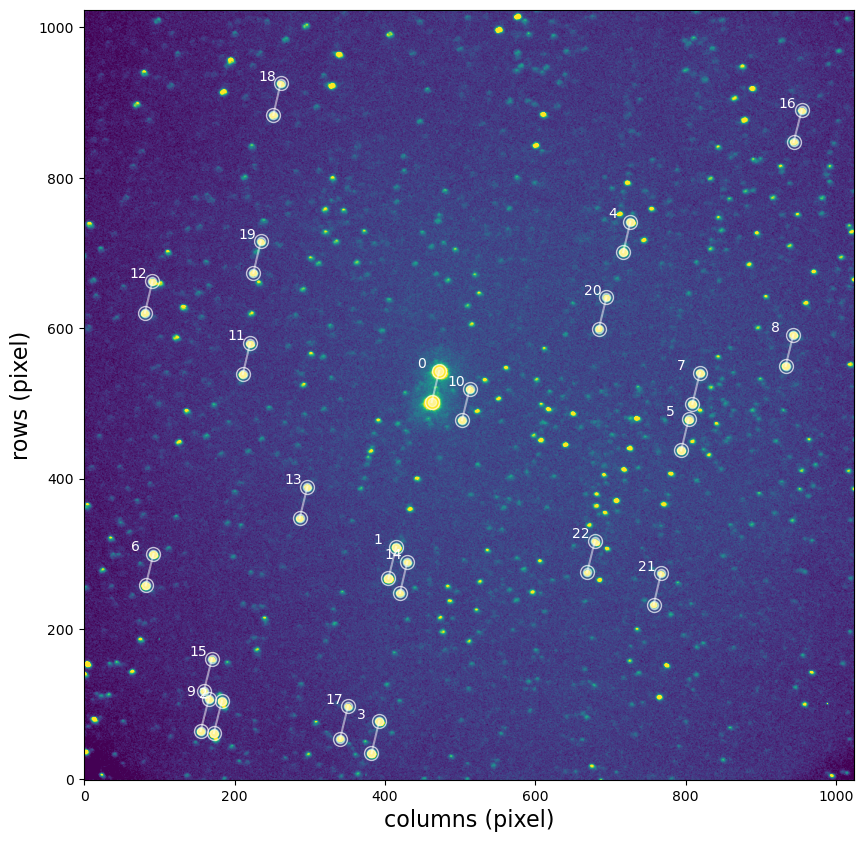

In [10]:
# run stack and reduce individual science image frames (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          pol_l2_list,
                                          reducedir,
                                          stack_suffix=l2_stack_suffix,
                                          force=FORCE,
                                          match_frames=True,
                                          polarimetry=True,                                              
                                          verbose=True,
                                          plot=True) 

## Calculate `HALF-WAVE (L/2)` POLARIMETRY

The half-wave ($\lambda/2$) polarimetry is calculated using the [dual beam polarimetry method](https://astropop.readthedocs.io/en/latest/reduction/polarimetry.html). It is executed in two steps. First run the routine ``s4utils.select_polar_sequence`` to automatically identify and select polarimetric sequences from the input list of files.  Then run ``s4pipelib.compute_polarimetry`` for each sequence to obtain the corresponding polarimetric measurements. The results are save into the ``polar.fits`` product FITS file. The polarimetry results can be accessed using the routine ``s4pipelib.get_polarimetry_results``, as in the example below. 

In [11]:
# input reduced files list
red_pol_l2_list = ["{}/{}".format(reducedir, os.path.basename(f).replace(".fits","_proc.fits")) for f in pol_l2_list]
    
# group input list into polarimetric sequences
pol_sequences = s4utils.select_polar_sequences(red_pol_l2_list, 
                                               sortlist=True, 
                                               npos_in_seq=16, 
                                               rolling_seq=False, 
                                               verbose=True)

Sequence 1 of 1 : 16 files for 16 waveplate positions


Number of sources in catalog: 23
Number of apertures: 6  varying from 6.0 to 16.0 in steps of 2.0 pix
Calculating halfwave polarimetry for aperture 1 of 6
Calculating halfwave polarimetry for aperture 2 of 6
Calculating halfwave polarimetry for aperture 3 of 6
Calculating halfwave polarimetry for aperture 4 of 6
Calculating halfwave polarimetry for aperture 5 of 6
Calculating halfwave polarimetry for aperture 6 of 6
Saving output halfwave polarimetry product: /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604//20230604_s4c1_000471_stdpol_l2_polar.fits
Source index: i=0 
Source RA=280.0080002066087 Dec=-12.3987251637656 mag=-19.1707+-0.0002
Best aperture radius: 14.0 pixels
Polarization in Q: -0.0390+-0.0003
Polarization in U: 0.0189+-0.0003
Polarization in V: nan+-nan
Total linear polarization p: 0.0433+-0.0003
Angle of polarization theta: 77.1+-0.2
Free constant k: 1+-nan
Zero of polarization: 0.0+-0.0
RMS of zi residuals: 0.00066
Reduced chi-square (n=16.0, DOF=14.0): 0.8

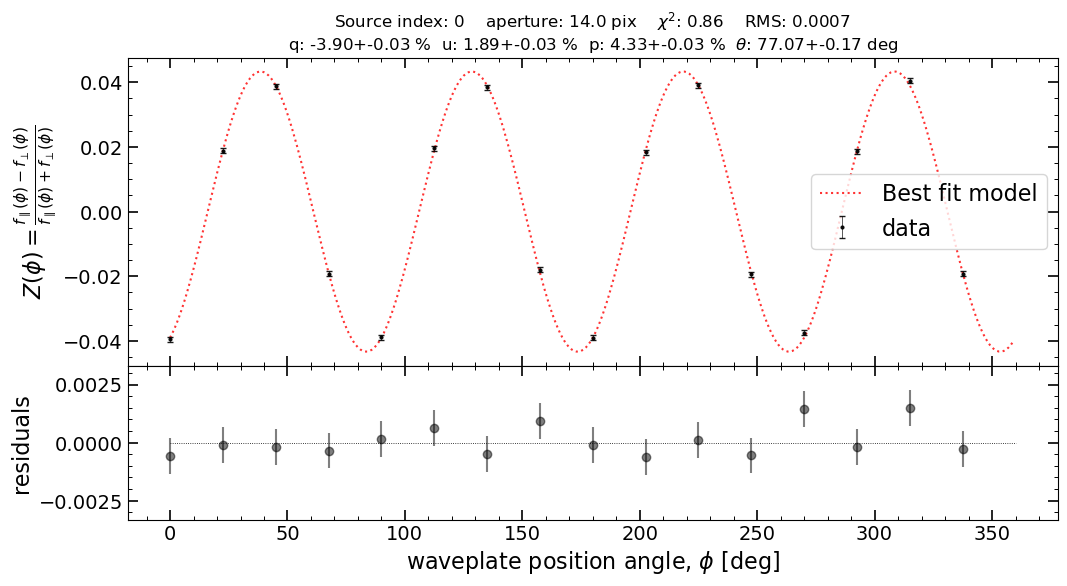

In [12]:
l2_polar_products = []

for i in range(len(pol_sequences)) :    
        
    if len(pol_sequences[i]) == 0 :
        continue
            
    polarproduct = s4pipelib.compute_polarimetry(pol_sequences[i], 
                                                 wppos_key = 'WPPOS',
                                                 wave_plate = 'halfwave',
                                                 base_aperture = p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                 compute_k = True,
                                                 fit_zero = False,
                                                 force = FORCE,
                                                 zero = 0)

    pol_results = s4pipelib.get_polarimetry_results(polarproduct,
                                                    source_index=0,
                                                    min_aperture=4,
                                                    max_aperture=25,
                                                    plot=True,
                                                    verbose=True)
    
    l2_polar_products.append(polarproduct)

## Time series of `HALF-WAVE (L/2)` polarimetry data

In this section, we compile all selected polarimetric sequences into a time series product using the routine ``s4pipelib.polar_time_series``. However, for this particular example, since there is only one polarimetric sequence, the time series is not particularly relevant, as it contains only one point in time.

In [13]:
# set suffix for output time series filename
ts_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR,
                                   CHANNEL,
                                   OBJECTID.replace(" ",""), 
                                   polsuffix)    

# Calculate polarimetric time series (ts) and save results to ts product
PolarTimeSeriesProduct = s4pipelib.polar_time_series(l2_polar_products,
                                                     reduce_dir=reducedir,
                                                     ts_suffix=ts_suffix,
                                                     aperture_radius=p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                     min_aperture=p['MIN_APERTURE_FOR_POLARIMETRY'],
                                                     max_aperture=p['MAX_APERTURE_FOR_POLARIMETRY'],
                                                     force=FORCE)

Packing time series data for polar file 1 of 1


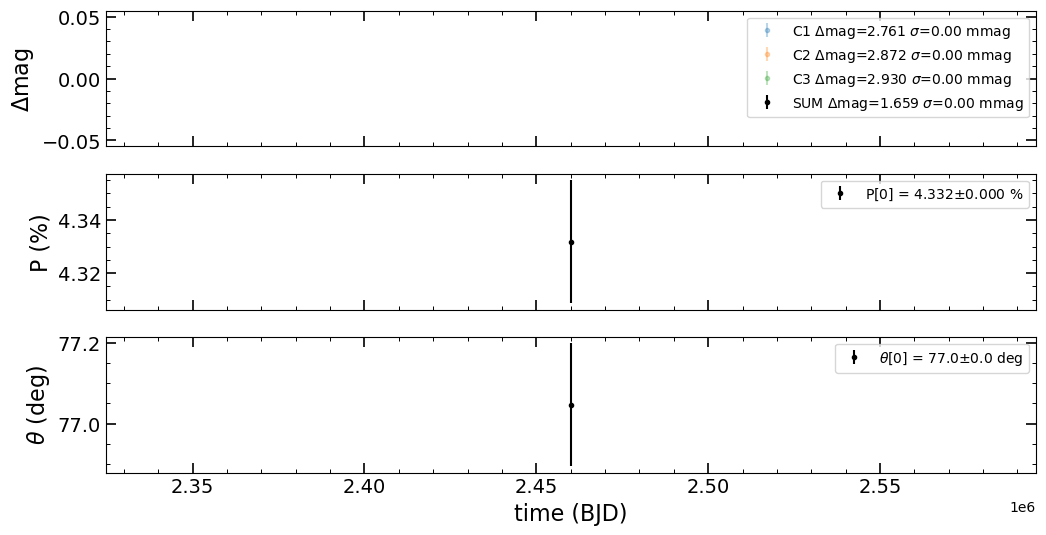

In [14]:
# plot polarimetric time series product
#   in this example the time series has only 1 point
s4plt.plot_polar_time_series(PolarTimeSeriesProduct, 
                             target=0, 
                             comps=[1,2,3], 
                             plot_total_polarization=True, 
                             plot_polarization_angle=True)

## Reduce scientific exposures in `POLARIMETRY QUARTER-WAVE (L/4)` mode

Now repeat all the reduction procedures above for the L/4 data.

In [15]:
# initial set up
polar_mode = p['POLARIMETRY_L4_KEYVALUE']
polsuffix = "_{}_{}".format(inst_mode,polar_mode)

# set suffix for output stack filename
l4_stack_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR, 
                                        CHANNEL, 
                                        OBJECTID.replace(" ",""), 
                                        polsuffix)

# make a list of quarter-wave files (L4)
pol_l4_list = s4utils.select_fits_files_with_keyword(pol_list, 'WPSEL', 'L4')

0 Reference image: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000487_stdpol.fits
OBJECT files: 10
Loading science frames to memory ... 
gain: 3.37 electron / adu
Calibrating science frames (CR, gain, bias, flat) ... 
Calibrating science frame 1 of 10 : 20230604_s4c1_000487_stdpol.fits 
Calibrating science frame 2 of 10 : 20230604_s4c1_000492_stdpol.fits 
Calibrating science frame 3 of 10 : 20230604_s4c1_000497_stdpol.fits 
Calibrating science frame 4 of 10 : 20230604_s4c1_000501_stdpol.fits 
Calibrating science frame 5 of 10 : 20230604_s4c1_000502_stdpol.fits 
Calibrating science frame 6 of 10 : 20230604_s4c1_000494_stdpol.fits 
Calibrating science frame 7 of 10 : 20230604_s4c1_000488_stdpol.fits 
Calibrating science frame 8 of 10 : 20230604_s4c1_000491_stdpol.fits 
Calibrating science frame 9 of 10 : 20230604_s4c1_000498_stdpol.fits 
Calibrating science frame 10 of 10 : 20230604_s4c1_000500_stdpol.fits 


2024-04-18 16:23:53,391 astropop - INFO - Registering image 1 from 10  [register]
2024-04-18 16:23:53,393 astropop - INFO - Images are equal, skipping registering.  [register]
2024-04-18 16:23:53,520 astropop - INFO - Registering image 2 from 10  [register]


Registering science frames and stacking them ... 
0 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000487_stdpol.fits
1 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000492_stdpol.fits
2 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000497_stdpol.fits
3 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000501_stdpol.fits
4 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000502_stdpol.fits
5 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000494_stdpol.fits
6 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000488_stdpol.fits
7 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000491_stdpol.fits
8 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000498_stdpol.fits
9 /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000500_stdpol.fits


2024-04-18 16:23:53,649 astropop - INFO - Filling registered image with cval=650.69  [register]
2024-04-18 16:23:53,653 astropop - INFO - Registering image with: translation=[-0.25 -0.75], rotation=0.00°  [register]
2024-04-18 16:23:53,868 astropop - INFO - Registering image 3 from 10  [register]
2024-04-18 16:23:53,993 astropop - INFO - Filling registered image with cval=632.06  [register]
2024-04-18 16:23:53,998 astropop - INFO - Registering image with: translation=[-0.25 -1.  ], rotation=0.00°  [register]
2024-04-18 16:23:54,318 astropop - INFO - Registering image 4 from 10  [register]
2024-04-18 16:23:54,487 astropop - INFO - Filling registered image with cval=634.08  [register]
2024-04-18 16:23:54,488 astropop - INFO - Registering image with: translation=[-0.5 -0. ], rotation=0.00°  [register]
2024-04-18 16:23:54,791 astropop - INFO - Registering image 5 from 10  [register]
2024-04-18 16:23:54,918 astropop - INFO - Filling registered image with cval=630.07  [register]
2024-04-18 1

Creating new catalog of detected sources:
Solving astrometry in POLAR-MODE using astrometry_from_existing_wcs()
Running photometry for multiple apertures:
Aperture radius of 6 pixels: 1 of 6 :
Aperture radius of 8 pixels: 2 of 6 :
Aperture radius of 10 pixels: 3 of 6 :
Aperture radius of 12 pixels: 4 of 6 :
Aperture radius of 14 pixels: 5 of 6 :
Aperture radius of 16 pixels: 6 of 6 :
The 16 images will be reduced in 1 loops of 100 images each time
Running loop 0 of 1 -> images in loop: 0 to 16 ... 
OBJECT files: 16
Creating output list of processed science frames ... 
1 of 16 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604/20230604_s4c1_000487_stdpol_proc.fits
2 of 16 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604/20230604_s4c1_000492_stdpol_proc.fits
3 of 16 is reduced? False -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604/20230604_s4c1_000497_stdpol_proc.fits
4 of 16 is reduced? False -> /Users

2024-04-18 16:24:09,158 astropop - INFO - Computing shift of image 1 from 16  [register]
2024-04-18 16:24:09,159 astropop - INFO - Computing shift of image 2 from 16  [register]
2024-04-18 16:24:09,355 astropop - INFO - Computing shift of image 3 from 16  [register]


Calculating offsets ... 
Computing offsets with respect to the reference image: index=0 -> /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000487_stdpol.fits


2024-04-18 16:24:09,800 astropop - INFO - Computing shift of image 4 from 16  [register]
2024-04-18 16:24:10,195 astropop - INFO - Computing shift of image 5 from 16  [register]
2024-04-18 16:24:10,603 astropop - INFO - Computing shift of image 6 from 16  [register]
2024-04-18 16:24:10,914 astropop - INFO - Computing shift of image 7 from 16  [register]
2024-04-18 16:24:11,060 astropop - INFO - Computing shift of image 8 from 16  [register]
2024-04-18 16:24:11,194 astropop - INFO - Computing shift of image 9 from 16  [register]
2024-04-18 16:24:11,323 astropop - INFO - Computing shift of image 10 from 16  [register]
2024-04-18 16:24:11,434 astropop - INFO - Computing shift of image 11 from 16  [register]
2024-04-18 16:24:11,530 astropop - INFO - Computing shift of image 12 from 16  [register]
2024-04-18 16:24:11,642 astropop - INFO - Computing shift of image 13 from 16  [register]
2024-04-18 16:24:11,731 astropop - INFO - Computing shift of image 14 from 16  [register]
2024-04-18 16:24

Processing file: 20230604_s4c1_000487_stdpol.fits
Running aperture photometry for catalogs with an offset of dx=0.0 dy=0.0
Saving frame 1 of 16: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000487_stdpol.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604/20230604_s4c1_000487_stdpol_proc.fits
Processing file: 20230604_s4c1_000492_stdpol.fits
Running aperture photometry for catalogs with an offset of dx=-0.25 dy=-0.75
Saving frame 2 of 16: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000492_stdpol.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604/20230604_s4c1_000492_stdpol_proc.fits
Processing file: 20230604_s4c1_000497_stdpol.fits
Running aperture photometry for catalogs with an offset of dx=-0.25 dy=-1.0
Saving frame 3 of 16: /Users/eder/Data/SPARC4/minidata//sparc4acs1/20230604/20230604_s4c1_000497_stdpol.fits -> /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604/20230604_s4c1_000497_st

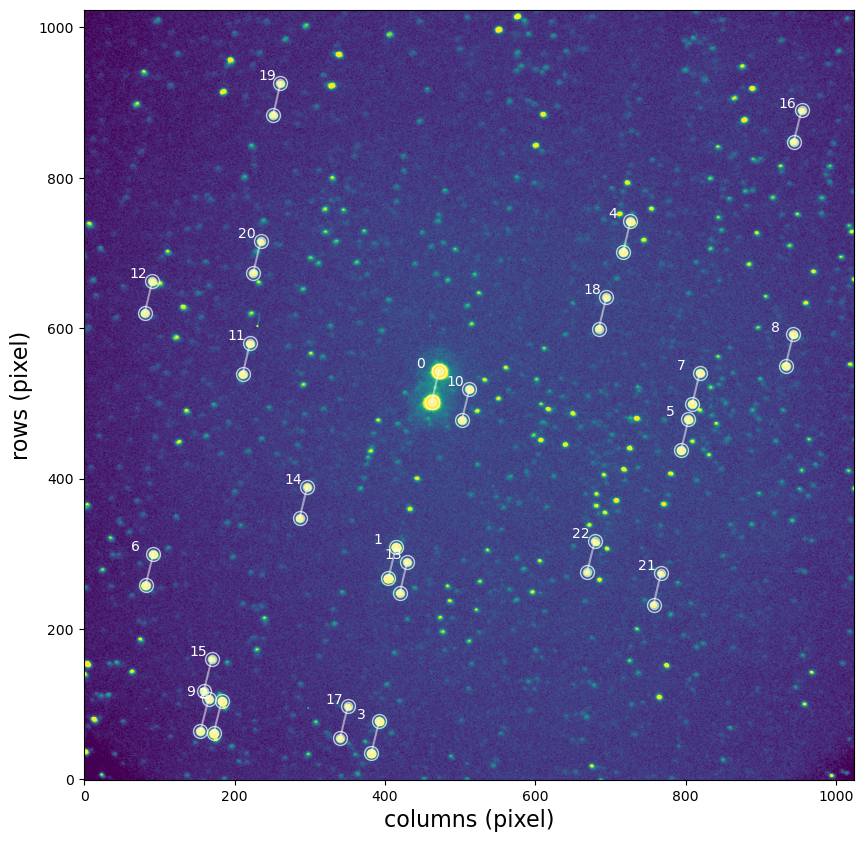

In [16]:
# run stack and reduce individual science images (produce *_proc.fits)
p = s4pipelib.stack_and_reduce_sci_images(p,
                                          pol_l4_list,
                                          reducedir,
                                          stack_suffix=l4_stack_suffix,
                                          force=FORCE,
                                          match_frames=True,
                                          polarimetry=True,                                              
                                          verbose=True,
                                          plot=True) 

## Calculate `QUARTER-WAVE (L/4)` POLARIMETRY

The quarter-wave ($\lambda/4$) polarimetry is calculated using the [dual beam polarimetry method](https://astropop.readthedocs.io/en/latest/reduction/polarimetry.html). It is executed in two steps. First run the routine ``s4utils.select_polar_sequence`` to automatically identify and select polarimetric sequences from the input list of files.  Then run ``s4pipelib.compute_polarimetry`` for each sequence to obtain the corresponding polarimetric measurements. The results are save into the ``polar.fits`` product FITS file. The polarimetry results can be accessed using the routine ``s4pipelib.get_polarimetry_results``, as in the example below. 

In [17]:
# input reduced files list
red_pol_l4_list = ["{}/{}".format(reducedir, os.path.basename(f).replace(".fits","_proc.fits")) for f in pol_l4_list]
    
# group input list into polarimetric sequences
pol_sequences = s4utils.select_polar_sequences(red_pol_l4_list, 
                                               sortlist=True, 
                                               npos_in_seq=16, 
                                               rolling_seq=False, 
                                               verbose=True)

Sequence 1 of 1 : 16 files for 16 waveplate positions


2024-04-18 16:24:26,090 astropop - INFO - Normalization disabled.  [__init__]


Number of sources in catalog: 23
Number of apertures: 6  varying from 6.0 to 16.0 in steps of 2.0 pix
Calculating quarterwave polarimetry for aperture 1 of 6
Calculating quarterwave polarimetry for aperture 2 of 6
Calculating quarterwave polarimetry for aperture 3 of 6
Calculating quarterwave polarimetry for aperture 4 of 6
Calculating quarterwave polarimetry for aperture 5 of 6
Calculating quarterwave polarimetry for aperture 6 of 6
Saving output quarterwave polarimetry product: /Users/eder/Data/SPARC4/minidata/reduced//sparc4acs1//20230604//20230604_s4c1_000487_stdpol_l4_polar.fits


2024-04-18 16:24:27,925 astropop - INFO - Normalization disabled.  [__init__]


Source index: i=0 
Source RA=280.00802140035375 Dec=-12.398713409665177 mag=-19.1397+-0.0002
Best aperture radius: 12.0 pixels
Polarization in Q: -0.0468+-0.0004
Polarization in U: -0.00+-0.05
Polarization in V: 0.0005+-0.0003
Total linear polarization p: 0.0468+-0.0004
Angle of polarization theta: 90.1+-0.2
Free constant k: 1+-nan
Zero of polarization: 10+-20
RMS of zi residuals: 0.00068
Reduced chi-square (n=16.0, DOF=12.0): 1.38


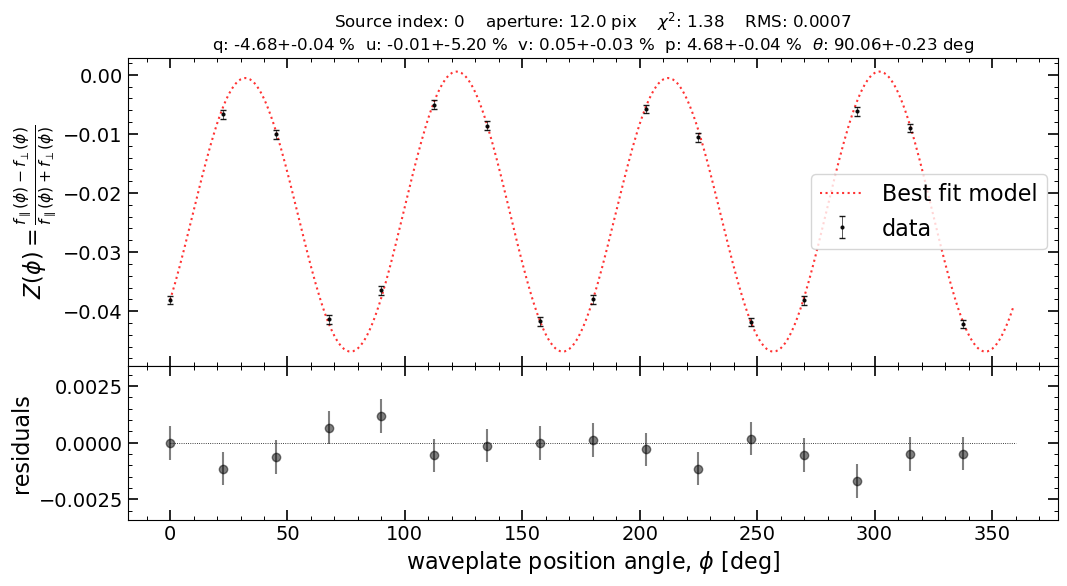

In [18]:
l4_polar_products = []

for i in range(len(pol_sequences)) :    
        
    if len(pol_sequences[i]) == 0 :
        continue
            
    polarproduct = s4pipelib.compute_polarimetry(pol_sequences[i], 
                                                 wppos_key='WPPOS',
                                                 wave_plate = 'quarterwave',
                                                 base_aperture = p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                 compute_k = False,
                                                 fit_zero = True,
                                                 force=FORCE,
                                                 zero = 0)

    pol_results = s4pipelib.get_polarimetry_results(polarproduct,
                                                    source_index=0,
                                                    min_aperture=4,
                                                    max_aperture=25,
                                                    plot=True,
                                                    verbose=True)
    l4_polar_products.append(polarproduct)    

## Time series of `QUARTER-WAVE (L/4)` polarimetry data

In [19]:
# set suffix for output time series filename
ts_suffix = "{}_s4c{}_{}{}".format(NIGHTDIR,
                                   CHANNEL,
                                   OBJECTID.replace(" ",""), 
                                   polsuffix)   

PolarTimeSeriesProduct = s4pipelib.polar_time_series(l4_polar_products,
                                                     reduce_dir=reducedir,
                                                     ts_suffix=ts_suffix,
                                                     aperture_radius=p['APERTURE_RADIUS_FOR_PHOTOMETRY_IN_POLAR'],
                                                     min_aperture=p['MIN_APERTURE_FOR_POLARIMETRY'],
                                                     max_aperture=p['MAX_APERTURE_FOR_POLARIMETRY'],
                                                     force=FORCE)

2024-04-18 16:24:28,149 astropop - INFO - Normalization disabled.  [__init__]


Packing time series data for polar file 1 of 1


2024-04-18 16:24:28,171 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:24:28,193 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:24:28,215 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:24:28,277 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:24:28,303 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:24:28,327 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:24:28,354 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:24:28,375 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:24:28,397 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:24:28,418 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:24:28,444 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:24:28,465 astropop - INFO - Normalization disabled.  [__init__]
2024-04-18 16:24:28,486 astropop - INFO - Normalization disabled

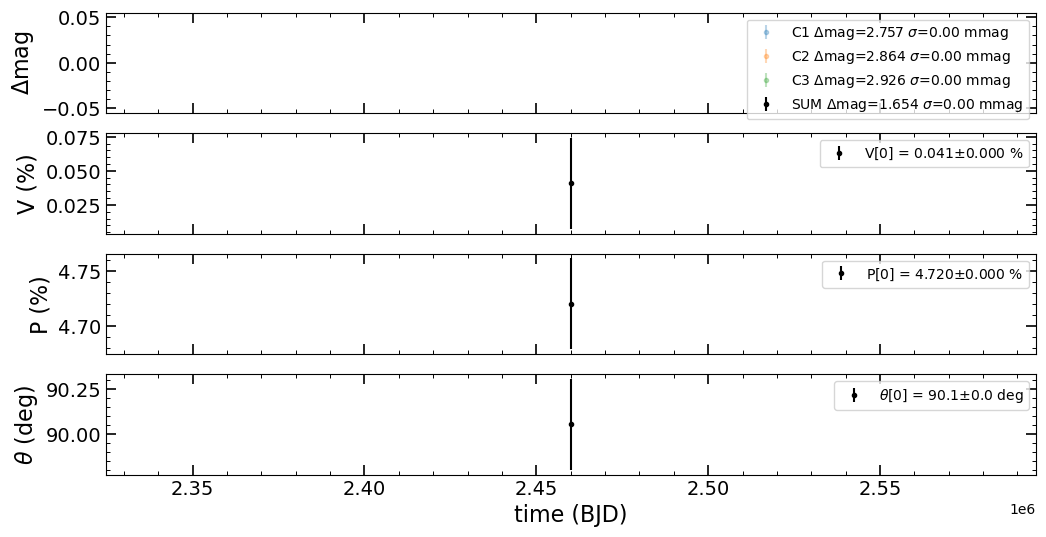

In [20]:
s4plt.plot_polar_time_series(PolarTimeSeriesProduct, 
                             target=0, 
                             comps=[1,2,3], 
                             plot_total_polarization=True, 
                             plot_polarization_angle=True)